In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)

/albedo/home/pscholz/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/options.py:93: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning,
/albedo/home/pscholz/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/options.py:93: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning,


/albedo/home/pscholz/tripyview


In [2]:
# Parameters
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'ghflx' # global heat flux

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'ghflx'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
box_region.append('moc_basins/Atlantic_MOC.shp')
box_region.append('moc_basins/IndoPacific_MOC.shp')
# box_region.append('ocean_basins/Atlantic_Basin.shp')
# box_region.append('ocean_basins/Pacific_Basin.shp')

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr, cnum = 'blue2red', 20
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995
#_____________________________________________________________________________________
which_dpi = 300
do_allcycl= False

In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    #__________________________________________________________________________________________________
    if do_allcycl: cycl_s=1
    else         : cycl_s=which_cycl    
    
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, which_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None) and (ref_path is not "None"): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, which_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
        
#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
else:
    do_reffig=False

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path is not "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = input_paths + ref_path, input_names + ref_name 
    else:    
        input_paths, input_names = input_paths + list([ref_path]), input_names + list([ref_name])
        
#______________________________________________________________________________________________________
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region is 'global' or isinstance(region,list): box.append(region)
    else: box.append(shp.Reader(os.path.join(shp_path,region)))            

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [4]:
#___LOAD FESOM2 DATA___________________________________________________________________________________    
hflx_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    data = tpv.load_data_fesom2(mesh, datapath, vname='fh', year=year, descript=descript, do_info=False)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________
    # compute meridional heat flux from surface heatflux fh by binning
    hflx_list.append(tpv.calc_gmhflx_box(mesh, data, box, dlat=1.0))
    del(data)

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
Atlantic
IndoPacific


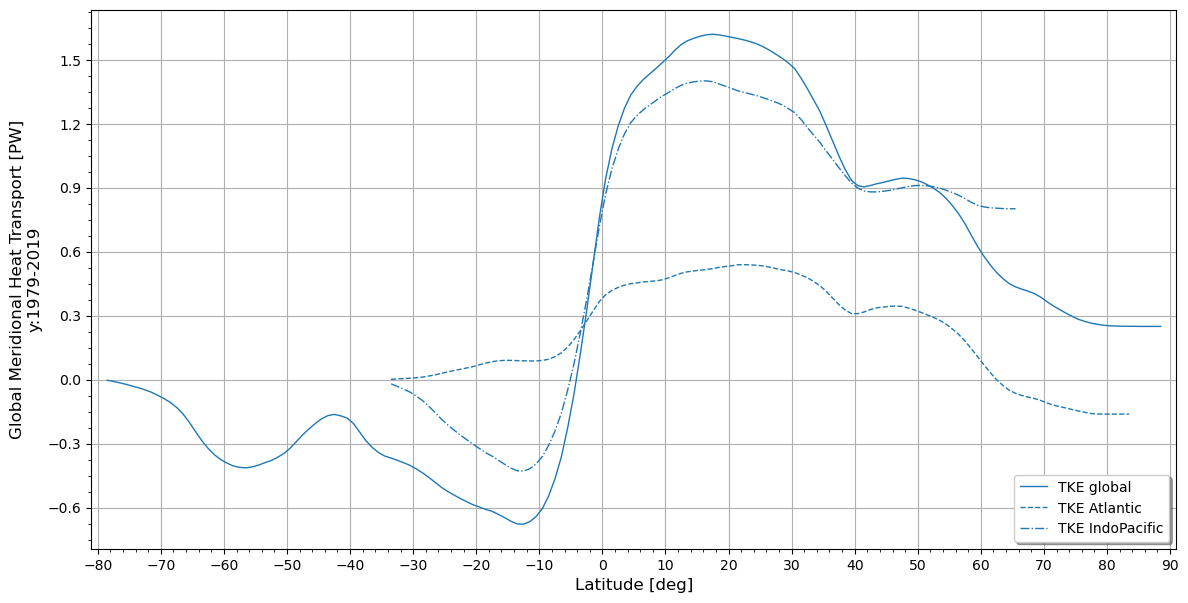

In [5]:
# #___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(hflx_list[0][0].keys())[0]
slabel = hflx_list[0][0][sname].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
if save_fname is not None: spath = save_fname
fig, ax = tpv.plot_mhflx(hflx_list, input_names, sect_name=None, figsize=[7*2, 3.5*2], 
                         do_allcycl=False, do_save=spath, save_dpi=which_dpi,)       